# Motivating example: Figure 4

Figure below is the motivating example in this paper: *Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks*. This graph contains one mediator $M_1$ that connects the exposure $X$ to the outcome $Y$.

In [1]:
import numpy as np

from eliater.examples.frontdoor_backdoor_discrete import (
    single_mediator_with_multiple_confounders_nuisances_discrete_example,
)
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.identify import Identification
from y0.dsl import P, Variable, X, Y
from y0.algorithm.estimation import estimate_ace
from y0.algorithm.identify import Identification, identify_outcomes
from eliater.discover_latent_nodes import find_nuisance_variables, mark_nuisance_variables_as_latent
from eliater.discover_latent_nodes import remove_nuisance_variables
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
graph = single_mediator_with_multiple_confounders_nuisances_discrete_example.graph

In [3]:
data = single_mediator_with_multiple_confounders_nuisances_discrete_example.generate_data(
    num_samples=500, seed=500
)

In [4]:
data.head()

,X,M1,Z1,Z2,Z3,R1,R2,R3,Y
0,1,1,1,1,1,1,1,1,1
1,1,1,1,0,0,1,1,1,1
2,1,0,1,0,1,1,1,0,1
3,1,1,1,1,1,1,1,1,0
4,1,1,1,1,0,1,1,1,1


## Step 1: Verify correctness of the network structure

In [5]:
print_graph_falsifications(graph, data, method="chi-square", verbose=True, significance_level=0.01)

Failed tests: 0/26 (0.00%)
Reject null hypothesis when p<0.01
======  =======  =======  =========  ========  =====  =======  ===================
left    right    given        stats         p    dof    p_adj  p_adj_significant
======  =======  =======  =========  ========  =====  =======  ===================
R3      X        M1|Z2    3.72468    0.444547      4        1  False
Y       Z1       X|Z2     3.842      0.427811      4        1  False
M1      R2       R1       0.148438   0.928469      2        1  False
R1      Z1       X        0.0530231  0.973837      2        1  False
R3      Z2       X|Z3     5.99107    0.112045      3        1  False
R3      Z3       R2|Y     0.149065   0.997357      4        1  False
R2      Y        R1       0.543749   0.76195       2        1  False
R1      Z2       X        3.57855    0.167081      2        1  False
M1      R3       R2|Y     0.901882   0.924291      4        1  False
R1      X        M1       0.227982   0.892266      2        1  False
R

All the d-separations implied by the network are validated by the data. No test failed. Hence, we can proceed to step 2.

## Step 2: Check query identifiability

The causal query of interest is the average treatment effect of $X$ on $Y$, defined as:
$E[Y|do(X=1)] - E[Y|do(X=0)]$.

In [6]:
identify_outcomes(graph=graph, treatments=X, outcomes=Y)

Sum[M1, Z1, Z2, Z3](P(M1 | X, Z1) * P(Y | M1, X, Z1, Z2, Z3) * P(Z2 | Z1) * P(Z3 | Z1, Z2) * Sum[M1, X, Y, Z2, Z3](Sum[R1, R2, R3](P(M1, R1, R2, R3, X, Y, Z1, Z2, Z3))))

The query is identifiable. Hence we can proceed to step 3.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [7]:
nuisance_variables = find_nuisance_variables(graph, treatments=X, outcomes=Y)
nuisance_variables

{R1, R2, R3}

The nuisance variables are $R_1$, $R_2$, and $R_3$.

## Step 4: Simplify the network

The following function finds the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules to remove the nuisance variables. As a result, running the 'find_nuisance_variables' and 'mark_nuisance_variables_as_latent' functions in step 3 is not necessary to get the value of step 4. However, we called them to illustrate the results. The new graph obtained in step 4 does not contain the nuisance variables. 

In [8]:
new_graph = remove_nuisance_variables(graph, treatments=X, outcomes=Y)

## Step 5: Estimate the query

In [9]:
ATE_value = estimate_ace(
    graph=new_graph, treatments=X, outcomes=Y, data=data
)
ATE_value

0.20915697893041166

The ATE amounts to 0.21 meaning that the average effect that $X$ has on $Y$ is negative.

# Evaluation Criterion

As we used synthetic data set, we were able to generate two interventional data sets where in
one X was set to 1, and the other one X is set to 0. The ATE was calculated by subtracting the average value of Y obtained from each interventional data,
resulting in the ground truth ATE=0.01. The ATE indicates that increase in X can increase  Y levels.

In [23]:
# get interventional data where EGFR is set to 1
intv_data_X_1 = single_mediator_with_multiple_confounders_nuisances_discrete_example.generate_data(
    num_samples=500, seed=500, treatments={X: 1}
)

# get interventional data where EGFR is set to 0
intv_data_X_0 = single_mediator_with_multiple_confounders_nuisances_discrete_example.generate_data(
    num_samples=500, seed=500, treatments={X: 0}
)

true_ate = intv_data_X_1.mean()["Y"] - intv_data_X_0.mean()["Y"] 
print(f"The true ATE is {true_ate:.04}")

The true ATE is 0.01


If you don't set the random seed and take a sampling over many generated datasets, you can plot the ATE. TODO: how to determine the convidence in the ATE?

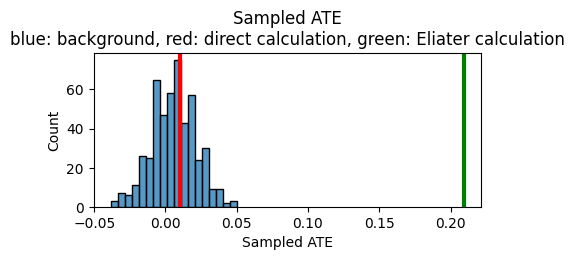

In [39]:
background_ates = []
for _ in range(500):
    intv_data_X_1 = single_mediator_with_multiple_confounders_nuisances_discrete_example.generate_data(
        num_samples=500, treatments={X: 1}
    )
    intv_data_X_0 = single_mediator_with_multiple_confounders_nuisances_discrete_example.generate_data(
        num_samples=500, treatments={X: 0}
    )
    background_ate = intv_data_X_1.mean()["Y"] - intv_data_X_0.mean()["Y"]
    background_ates.append(background_ate)

fix, ax = plt.subplots(1,1, figsize=(5, 2))
sns.histplot(background_ates, ax=ax)
ax.axvline(true_ate, linewidth=3, color="red")
ax.axvline(ATE_value, linewidth=3, color="green")
ax.set_xlabel("Sampled ATE")
ax.set_title("Sampled ATE\nblue: background, red: direct calculation, green: Eliater calculation")
plt.show()